<a href="https://colab.research.google.com/github/marinasemushina/-_-3/blob/main/hw_additional_%D0%A1%D0%B5%D0%BC%D1%83%D1%88%D0%B8%D0%BD%D0%B0%D0%9C%D0%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Дополнительное домашнее задание. Логистическая регрессия и решающие деревья**

Суммарно 10 баллов за всю работу. По 5 баллов в каждой части.

Требуется выполнить следующие задания.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random

from __future__ import annotations

## **Часть 1. Логистическая регрессия (5 баллов)**

**Задание 1 (3 балла)**. Реализуйте логистическую регрессию, обучаемую с помощью двух видов градиенткого спуска:
- полный (по всем данным) градиентный спуск;

- стохастический градиентный спуск;

Во всех пунктах необходимо соблюдать два условия:
- Циклы можно использовать только для итераций градиентного спуска.
- В качестве критерия останова необходимо использовать (одновременно):

    - проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка 1e-6), задаваемого параметром `tolerance`;
    - достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, добавьте атрибут класса `loss_history`. В нем после вызова метода `fit` должны содержаться значения функции потерь для всех итераций градиентного спуска, начиная с нулевой.

Инициализировать веса можно случайным образом или нулевым вектором.

In [2]:
from sklearn.base import BaseEstimator

from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc

from sklearn.model_selection import KFold

In [3]:
class MyLogisticRegression(BaseEstimator):
    def __init__(self, gd_type: str = 'stochastic', tolerance: float = 1e-6,
                 max_iter: int = 1000, eta: float = 1e-2,
                 w0: np.array = None) -> None:
        """
        Аргументы:
          gd_type: вид градиентного спуска ('full' или 'stochastic').

          tolerance: порог для остановки градиетного спуска.

          max_iter: максимальное количество шагов в градиентном спуске.

          eta: скорость обучения (learning rate).

          w0: массив размерности d (d — количество весов в оптимизации).
              Начальные веса.
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.eta = eta
        self.w0 = w0
        self.w = None
        self.loss_history = None


    def fit(self, X: np.array, y: np.array) -> MyLogisticRegression:
        """Обучаем модель на training данных. Сохраняйте значении функции потерь после каждой итерации.

        Аргументы:
          X: данные на обучение.

          y: целевая переменная.

        Возвращает:
          self: обученный регрессор.
        """
        self.loss_history = []
        # your code
        n_samples, n_features = X.shape
        self.w = self.w0 if self.w0 is not None else np.zeros(n_features)

        for iteration in range(self.max_iter):
            if self.gd_type == 'full':
                gradient = self.calc_gradient(X, y)
            elif self.gd_type == 'stochastic':
                idx = np.random.randint(n_samples)  # случайный индекс
                gradient = self.calc_gradient(X[idx:idx+1], y[idx:idx+1])
            else:
                raise ValueError("gd_type must be 'full' or 'stochastic'")

            self.w -= self.eta * gradient
            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)

            # Проверка условия остановки
            if np.linalg.norm(gradient) < self.tolerance:
                break
        return self


    def predict_proba(self, X: np.array) -> np.array:
        """Вычислите вероятности положительного и отрицательного классов для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n, 2).
             Предсказанные вероятности.
        """
        if self.w is None:
            raise Exception('Not trained yet')
        # your code
        linear_output = X @ self.w
        probabilities = 1 / (1 + np.exp(-linear_output))
        return np.column_stack((1 - probabilities, probabilities))
        pass


    def predict(self, X: np.array) -> np.array:
        """Предсказание метки класса для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n,).
             Предсказанные метки классов.
        """
        if self.w is None:
            raise Exception('Not trained yet')
        # your code
        probabilities = self.predict_proba(X)[:, 1]
        return (probabilities >= 0.5).astype(int)
        pass


    def calc_gradient(self, X: np.array, y: np.array) -> np.array:
        """Вычислите градиент функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d), n может быть равно 1, если выбран 'stochastic'.
          y: массив размером (n,).

        Возвращает:
          Массив размером (d,).
          Градиент функции потерь после текущей итерации.
        """
        # your code
        n_samples = X.shape[0]
        predictions = self.predict_proba(X)[:, 1]
        gradient = X.T @ (predictions - y) / n_samples
        return gradient
        pass


    def calc_loss(self, X: np.array, y: np.array) -> float:
        """Вычислите значение функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d).
          y: массив размером (n,).

        Возвращает:
          Значение функции потерь после текущей итерации.
        """
        # your code
        predictions = self.predict_proba(X)[:, 1]
        loss = -np.mean(y * np.log(predictions + 1e-15) + (1 - y) * np.log(1 - predictions + 1e-15))
        return loss
        pass

Далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

Сгенерируем искусственные данные.

In [4]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=999)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=999)

**Задание 2 (1 балл).** Обучите логистическую регрессию на искусственных данных. Нарисуйте изменение лосса во время обучения.

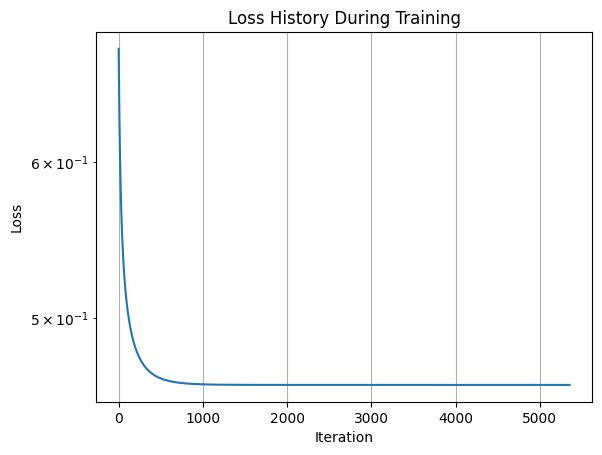

Accuracy on test set: 0.79


In [5]:
# your code
# Инициализация и обучение модели
model = MyLogisticRegression(gd_type='full', tolerance=1e-6, max_iter=10000, eta=0.01)
model.fit(X_train, y_train)

# Визуализация функции потерь
plt.plot(model.loss_history)
plt.title('Loss History During Training')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')  # Логарифмическая шкала для лучшей визуализации
plt.grid()
plt.show()

# Предсказания на тестовой выборке
predictions = model.predict(X_test)
accuracy = np.mean(predictions == y_test)
print(f'Accuracy on test set: {accuracy:.2f}')

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC- и PR-кривые.

ROC-AUC: 0.86
PR-AUC: 0.82


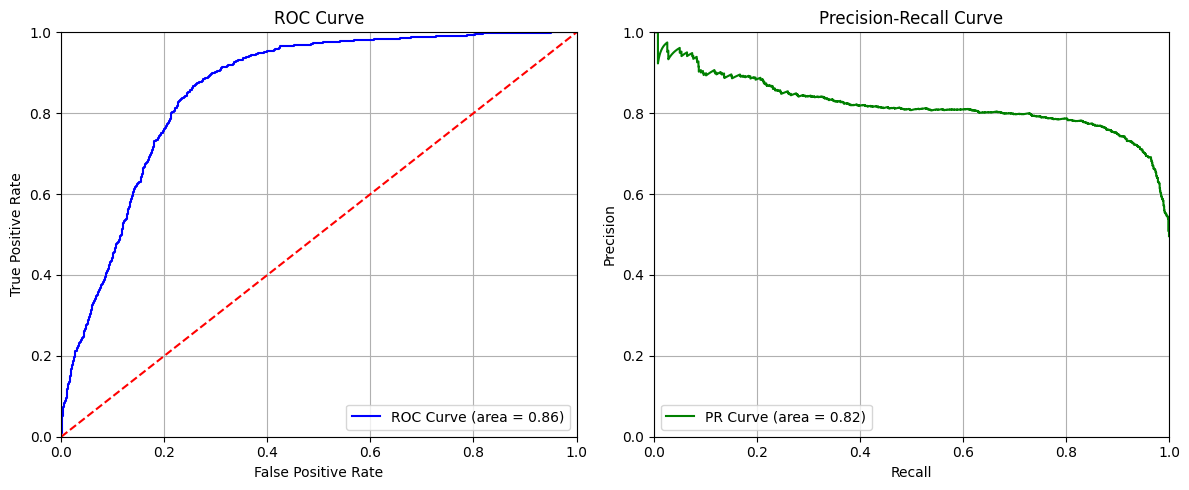

In [6]:
# your code
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
# Обучение модели на обучающей выборке
model = MyLogisticRegression(gd_type='full', tolerance=1e-6, max_iter=10000, eta=0.01)
model.fit(X_train, y_train)

# Предсказание вероятностей на тестовой выборке
y_proba_test = model.predict_proba(X_test)[:, 1]

# Расчет ROC-AUC и PR-AUC
roc_auc = roc_auc_score(y_test, y_proba_test)
pr_auc = average_precision_score(y_test, y_proba_test)

print(f'ROC-AUC: {roc_auc:.2f}')
print(f'PR-AUC: {pr_auc:.2f}')

# Построение ROC-кривой
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()

# Построение PR-кривой
precision, recall, _ = precision_recall_curve(y_test, y_proba_test)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', label='PR Curve (area = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc='lower left')
plt.grid()

plt.tight_layout()
plt.show()

**Задание 3 (1 балл).** Оцените ошибку ROC-AUC и PR-AUC вашей модели при помощи K-fold кросс-валидации.  

In [7]:
# your code
# Настройка K-fold кросс-валидации
kf = KFold(n_splits=5, shuffle=True, random_state=999)

roc_auc_scores = []
pr_auc_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Обучение модели
    model = MyLogisticRegression(gd_type='full', tolerance=1e-6, max_iter=10000, eta=0.01)
    model.fit(X_train, y_train)

    # Предсказание вероятностей на тестовой выборке
    y_proba_test = model.predict_proba(X_test)[:, 1]

    # Расчет ROC-AUC и PR-AUC
    roc_auc = roc_auc_score(y_test, y_proba_test)
    pr_auc = average_precision_score(y_test, y_proba_test)

    roc_auc_scores.append(roc_auc)
    pr_auc_scores.append(pr_auc)
# Выводим средние значения ROC-AUC и PR-AUC
print(f'Mean ROC-AUC: {np.mean(roc_auc_scores):.2f} ± {np.std(roc_auc_scores):.2f}')
print(f'Mean PR-AUC: {np.mean(pr_auc_scores):.2f} ± {np.std(pr_auc_scores):.2f}')


Mean ROC-AUC: 0.86 ± 0.00
Mean PR-AUC: 0.83 ± 0.01


## **Часть 2. Решающие деревья (5 баллов)**

Здесь требуется реализовать разбиение элементов выборки в вершине дерева.

$R_m$ — множество объектов в разбиваемой вершине, $j$ — номер признака, по которому происходит разбиение, $t$ — порог разбиения.

Критерий ошибки:

$$
Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r) \to \min_{j, t}
$$

$R_\ell$ — множество объектов в левом поддереве, $R_r$ — множество объектов в правом поддереве.

$H(R)$ — критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.

In [8]:
from typing import Iterable, List, Tuple

Так как Boston Dataset с недавних пор отсутствует в sklearn, то ниже реализован способ загрузки данного датасета из другого источника.

In [ ]:
# `load_boston` has been removed from scikit-learn since version 1.2.

#from sklearn.datasets import load_boston
#boston = load_boston()

In [ ]:
#!wget -i https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/datasets/data/boston_house_prices.csv


In [9]:
# Скачали файл напрямую с github по ссылке выше и загрузили
data_git = pd.read_csv('boston_house_prices.csv')

In [10]:
data_git.head()


,506,13,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
1,0.00632,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24
2,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6
3,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4


**Data Set Characteristics:**  

    :Number of Instances: 506

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
.. topic:: References

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.



In [11]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [12]:
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

X = pd.DataFrame(data, columns=feature_names, index=range(len(data)))
y = pd.DataFrame(target, columns=['MEDV'], index=range(len(target)))

X['target'] = y

In [13]:
X_train, X_test = train_test_split(X, test_size=0.25, random_state=999)

**Задание 1 (1 балл)**. Реализуйте подсчет критерия ошибки. Для этого реализуйте функции для подсчета значения критерия информативности, а также для разбиения вершины.

In [14]:
def H(R: np.array) -> float:
    """
    Вычислить критерий информативности (impurity criterion) для фиксированного набора объектов R.
    Предполагается, что последний столбец содержить целевую переменную.
    """
    # your code
     # Получаем целевую переменную
    y = R[:, -1]

    # Вычисляем среднее значение целевой переменной
    mean_y = np.mean(y)

    # Вычисляем среднеквадратичную ошибку
    impurity = np.mean((y - mean_y) ** 2)

    return impurity


def split_node(R_m: np.array, feature: str, t: float) -> Iterable[np.array]:
    """
    Разделить фиксированный набор объектов R_m с заданным признаком (номером признака) и пороговым значением t.
    """
    # your code
    # Определяем индекс признака
    feature_index = feature_names.index(feature)

    # Разделяем данные на две части
    left_split = R_m[R_m[:, feature_index] <= t]
    right_split = R_m[R_m[:, feature_index] > t]

    return left_split, right_split


def q_error(R_m: np.array, feature: str, t: float) -> float:
    """
    Вычислить критерий ошибки для заданных параметров разделения.
    """
    # your code
     # Разделяем набор данных
    left_split, right_split = split_node(R_m, feature, t)

    # Вычисляем критерий информативности для каждого поднабора
    impurity_left = H(left_split) if len(left_split) > 0 else 0
    impurity_right = H(right_split) if len(right_split) > 0 else 0

    # Вычисляем общую ошибку
    total_impurity = (len(left_split) * impurity_left + len(right_split) * impurity_right) / len(R_m)

    return total_impurity


**Задание 2 (1 балл)**. Переберите все возможные разбиения обучающей выборки по одному из признаков и постройте график критерия ошибки в зависимости от значения порога.

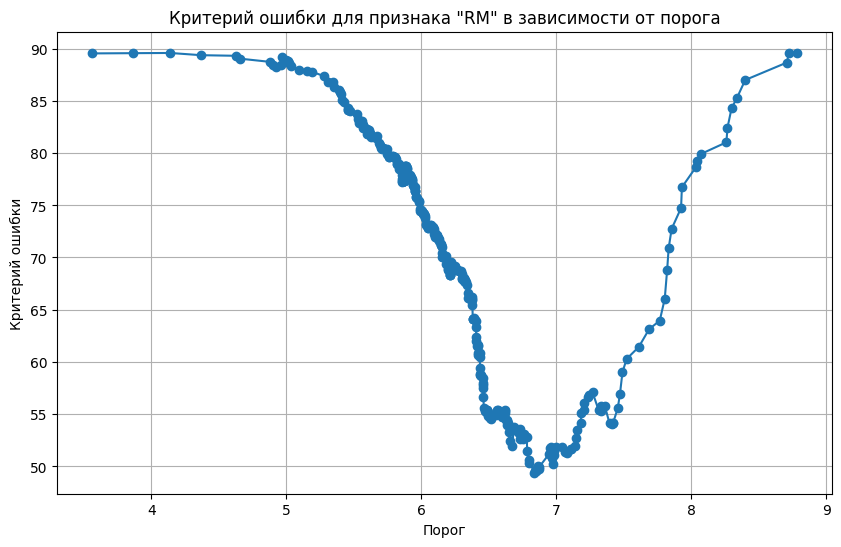

In [15]:
# your code
# Функция для перебора значений порога и построения графика
def plot_error_by_threshold(feature: str):
    R_m = X_train.values  # Получаем значения из обучающей выборки
    thresholds = np.unique(X_train[feature])
    errors = []

    for t in thresholds:
        error = q_error(R_m, feature, t)
        errors.append(error)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, errors, marker='o')
    plt.title(f'Критерий ошибки для признака "{feature}" в зависимости от порога')
    plt.xlabel('Порог')
    plt.ylabel('Критерий ошибки')
    plt.grid()
    plt.show()

# Выберите признак для анализа
feature_to_analyze = 'RM'
plot_error_by_threshold(feature_to_analyze)

**Задание 3  (1 балл)**. Напишите функцию, находящую оптимальное разбиение данной вершины по данному признаку.

In [16]:
def get_optimal_split(R_m: np.array, feature: str) -> Tuple[float, List[float]]:
    # your code
    best_threshold = None
    best_error = float('inf')  # Начальное значение ошибки - бесконечность
    errors = []  # Список для хранения значений критерия ошибки

    # Получаем индекс признака
    feature_index = feature_names.index(feature)

    # Получаем уникальные значения для данного признака
    unique_values = np.unique(R_m[:, feature_index])

    # Перебираем все уникальные значения как потенциальные пороги
    for t in unique_values:
        error = q_error(R_m, feature, t)  # Вычисляем ошибку для каждого порога
        errors.append(error)  # Добавляем значение ошибки в список

        # Если текущая ошибка меньше, чем лучшая найденная ошибка, обновляем
        if error < best_error:
            best_error = error
            best_threshold = t

    return best_threshold, errors

**Задание 4  (1 балл)**. Для первого разбиения найдите признак, показывающий наилучшее качество. Каков порог разбиения и значение качества? Постройте график критерия ошибки для данного признака в зависимости от значения порога.

Лучший признак: RM
Оптимальный порог: 6.833
Значение критерия ошибки: 49.38089500362002


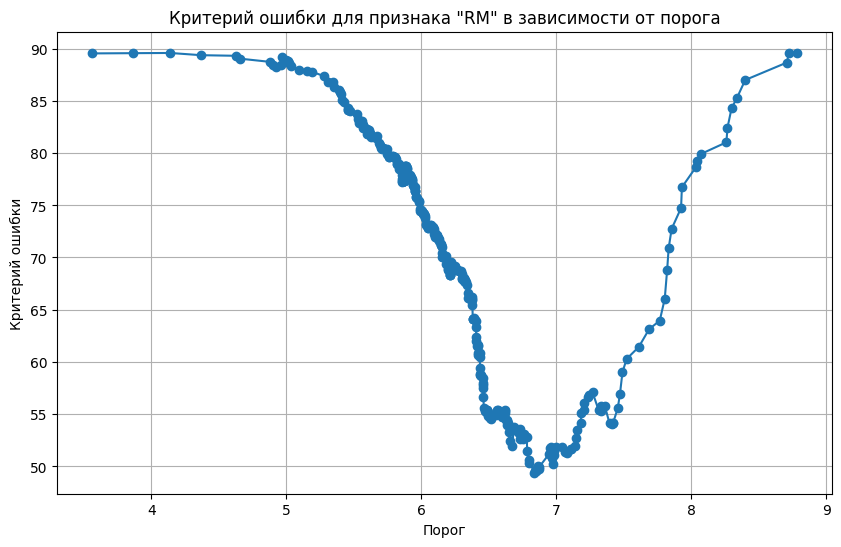

In [17]:
# your code
# Получаем значения из обучающей выборки
R_m = X_train.values

# Инициализируем переменные для хранения наилучшего результата
best_feature = None
best_threshold = None
best_error = float('inf')

# Перебираем все признаки
for feature in feature_names:
    threshold, errors = get_optimal_split(R_m, feature)
    min_error = min(errors)

    # Если текущая ошибка меньше, чем лучшая найденная ошибка, обновляем
    if min_error < best_error:
        best_error = min_error
        best_feature = feature
        best_threshold = threshold

# Выводим результаты
print(f"Лучший признак: {best_feature}")
print(f"Оптимальный порог: {best_threshold}")
print(f"Значение критерия ошибки: {best_error}")

# Построим график для лучшего признака
plot_error_by_threshold(best_feature)

 **Задание 5 (1 балл)**. Изобразите разбиение визуально. Для этого постройте диаграмму рассеяния целевой переменной в зависимости от значения входного признака. Далее изобразите вертикальную линию, соответствующую порогу разбиения.

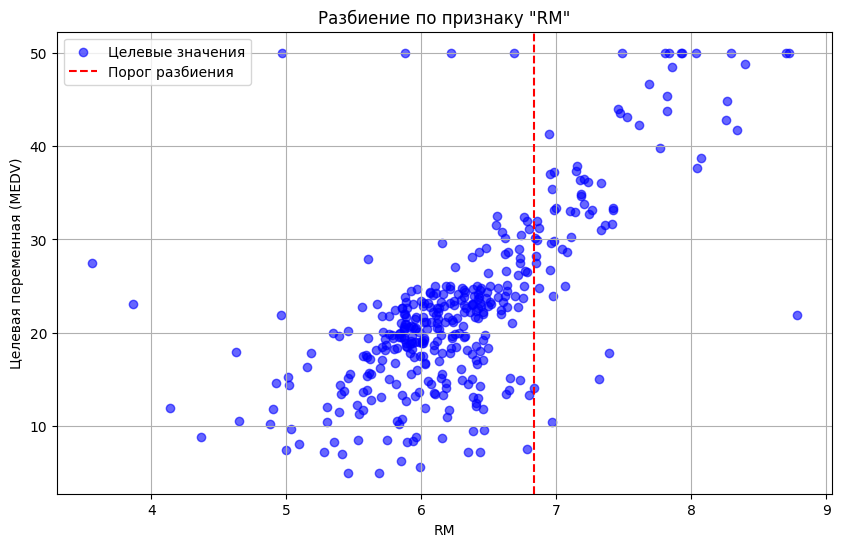

In [18]:
# your code
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y['MEDV'], test_size=0.25, random_state=999)
def plot_split_visualization(X: pd.DataFrame, y: pd.DataFrame, feature: str, threshold: float):
    plt.figure(figsize=(10, 6))

    # Построение диаграммы рассеяния
    plt.scatter(X[feature], y, alpha=0.6, color='blue', label='Целевые значения')

    # Добавление вертикальной линии для порога разбиения
    plt.axvline(x=threshold, color='red', linestyle='--', label='Порог разбиения')

    # Настройка графика
    plt.title(f'Разбиение по признаку "{feature}"')
    plt.xlabel(feature)
    plt.ylabel('Целевая переменная (MEDV)')
    plt.legend()
    plt.grid()
    plt.show()
# Вызов функции для визуализации с правильными параметрами
plot_split_visualization(X_train, y_train.values, best_feature, best_threshold)
